<a href="https://colab.research.google.com/github/Asandandlela16/Modelling-and-Predicting-Crop-Health-Using-Remote-Sensing-Data-and-Neural-Networks/blob/main/Modelling%20and%20Predicting%20Crop%20Health%20Using%20Remote%20Sensing%20Data%20and%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelling and Predicting Crop Health Using Remote Sensing Data and Neural Networks

#### So here we want to perform remote remote sensing data analysis using raster and vector data focusing on vegetation health assessment. The classification model is a Neural Network that is gonna be built using tensorflow.

1. Import the necessary libraries :

In [2]:
pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 89.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

**2.Load raster data. You will find the zip file containing the dataset on my git. I had originally downloaded the dataset from dronemapper's github.**

Load *DEM(Digital Elevation Model)*, *Orthophoto(multiband)* and *DTM( Digital Terrain Model)* using rasterio

In [4]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [5]:
import zipfile
import io

for fname, fcontent in uploaded.items():
    with zipfile.ZipFile(io.BytesIO(fcontent)) as z:
        z.extractall("/content/data")


In [8]:
dem=rasterio.open('/content/data/data/dem.tif')
ortho=rasterio.open('/content/data/data/ortho.tif')
dtm=rasterio.open('/content/data/data/dtm.tif')

3.Read arrays from raster data

Read the first band fro dem and dtm and the first 6 for ortho

In [9]:
dem_arr=dem.read(1)
ortho_arr=ortho.read([1,2,3,4,5,6])
dtm_arr=dtm.read(1)

4.Load the vector data and the shapefiles from the zip

In [11]:
plots_1=gpd.read_file('/content/data/data/plots_1.shp')
plots_2=gpd.read_file('/content/data/data/plots_2.shp')

5.mask invalid data

set invalid elevation and thermal values to  NaN

In [12]:
elevation=np.where(dem_arr<0,np.nan,dem_arr)
#thermal=np.where(ortho_arr<0,np.nan,ortho_arr)
masked_thermal=np.where(ortho_arr[5]<= 0, np.nan, ortho_arr[5]/ 100-273.15)   #convert to celcius

6.Generate NDVI(Normalized Difference Vegetation Index) with error handling

  NDVI = (NIR - Red)/ (NIR + Red)

In [15]:
pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 85.4 MB/s eta 0:00:00


In [20]:
with np.errstate(divide="ignore", invalid="ignore") :
  ndvi= (ortho_arr[3] - ortho_arr[0] ) / ( ortho_arr[3] + ortho_arr[0])
  ndvi=np.where(np.isnan(ndvi),0 , ndvi)

#### Compute zonal statistics for each plots

In [27]:
def compute_zonal_stats(plots, data, affine) :
   import rasterstats as rs
   plots_zs= rs.zonal_stats(plots, data, affine=affine, stats="mean", nodata=np.nan, geojson_out=True)
   return gpd.GeoDataFrame.from_features(plots_zs)

#Calculate mean NDVI, elevation, thermal, and  DTM values for ech plot
plots_1['NDVI_mean']=compute_zonal_stats(plots_1, ndvi, dem.transform)['mean']
plots_1['elevation_mean']=compute_zonal_stats(plots_1, elevation, dem.transform)['mean']
plots_1['Thermal_mean']=compute_zonal_stats(plots_1, masked_thermal, dem.transform)['mean']
plots_1['DTM_mean']=compute_zonal_stats(plots_1, dtm_arr, dem.transform)['mean']

## DATA PREPARATION

In [29]:
plots_1=plots_1.dropna()
features=plots_1[['NDVI_mean', 'elevation_mean', 'Thermal_mean', 'DTM_mean']]


1. Creating a synthetic target variable for healthy crops ( use 0.4 and 0.8 for NDVI range)

In [31]:
healthy_mask= (plots_1['NDVI_mean']>= 0.4) & (plots_1['NDVI_mean']<=0.8)
plots_1['synthetic_target']=np.where(healthy_mask,1,0)  #healthy crops=1 , other=0

2. Check for imbalance and print class distribution

In [36]:
class_counts=plots_1['synthetic_target'].value_counts()
print("class distribution" ,class_counts)

# We handle data imbalance in this scenario by undersampling the majority group
from sklearn.utils import resample

#separate minority and majority classes
#This variable indicate whether a variable is healthy or not
minority_class=plots_1[plots_1['synthetic_target']==1]
majority_class=plots_1[plots_1['synthetic_target']==0]

# Resample the majority class to match the minority class size
majority_class_downsampled=resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)
balanced_data=pd.concat([majority_class_downsampled, minority_class])

# now we set new features and target variable from  the balanced data
features = balanced_data[['NDVI_mean','Thermal_mean', 'elevation_mean', 'DTM_mean']]
target = balanced_data['synthetic_target']

class distribution synthetic_target
0    78
1    54
Name: count, dtype: int64


3. Split the data into training and testing sets

In [37]:
x_train, x_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)


4. Standardize data(standardize the features to have 0 mean and variance)

In [39]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

5. Define the neural network model
  
    The model has 3 layers: Two hidden layers with dropout and an output layer with sigmoid activation for binary classification

In [42]:
model=Sequential([
    Dense(128, activation="relu", input_shape=(x_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])


Compile the model  now!

In [43]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

6. Train the model and on 100 epochs( validation split of 20%)

In [45]:
history=model.fit(x_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9926 - loss: 0.0679 - val_accuracy: 0.8889 - val_loss: 0.3111
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9697 - loss: 0.0830 - val_accuracy: 0.8889 - val_loss: 0.3025
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9809 - loss: 0.0689 - val_accuracy: 0.8889 - val_loss: 0.2950
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9619 - loss: 0.0961 - val_accuracy: 0.8889 - val_loss: 0.2899
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9809 - loss: 0.0951 - val_accuracy: 0.8889 - val_loss: 0.2876
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9697 - loss: 0.0920 - val_accuracy: 0.8889 - val_loss: 0.2868
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9697 - loss: 0.0923 - val_accuracy: 0.8889 - val_loss: 0.2877
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9697 - loss: 0.0783 - val_accuracy: 0.8889 - val_loss:

## Evaluate the model

ON TEST DATA

In [48]:
loss, accuracy=model.evaluate(x_test, y_test)

print(" Accuracy on the test data:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9091 - loss: 0.0933
 Accuracy on the test data: 0.9090909361839294


Let's make predictions

In [49]:
predictions=(model.predict(x_test)> 0.5).astype('int32')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


EVALUATION METRICS

compute accuracy, precision, recall, f1_score , and ROC AUC score

In [51]:
accuracy_score_val = accuracy_score(y_test, predictions)
precision_score_val = precision_score(y_test, predictions)
recall_score_val = recall_score(y_test, predictions)
roc_auc_score_val = roc_auc_score(y_test, model.predict(x_test))

print("Accuracy:", accuracy_score_val)
print("Precision:", precision_score_val)
print("Recall:", recall_score_val)
print("ROC AUC Score:", roc_auc_score_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Accuracy: 0.9090909090909091
Precision: 1.0
Recall: 0.8333333333333334
ROC AUC Score: 1.0


### CONFUSUION MATRIX TO VISUALIZE THE PERFORMANCE OF THE MODEL

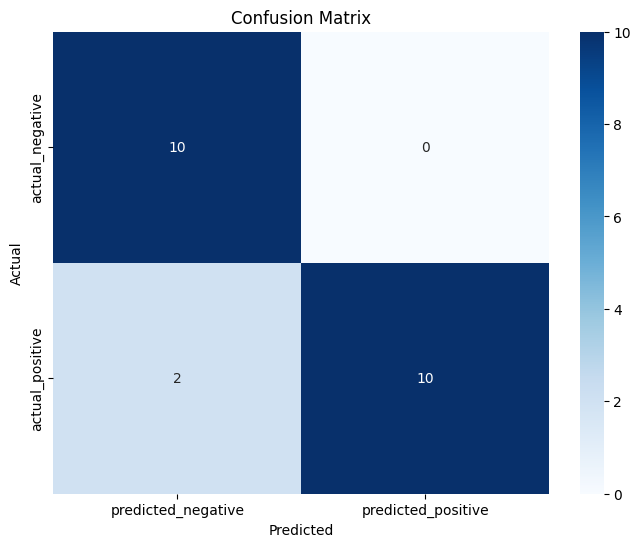

In [56]:
#compute the confusion matrix
conf_matrix=confusion_matrix(y_test, predictions)

#plot the matrix using seabron

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['predicted_negative', 'predicted_positive'],
            yticklabels=['actual_negative', 'actual_positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Conclusion

As you can see the model has an accuracy of 90+% thus it can relatively distinguish between health and unhealthy plants and plots.